# Radar Mosiac Plotting

This notebook is an example of downloading, gridding, and plotting radar mosiacs

In [183]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import requests

from datetime import datetime, timedelta
from netCDF4 import Dataset

import glob
import os

import pyart

import pandas as pd
import numpy as np

import zipfile
import shutil
import gzip

from mrms.ingest import ldm
from mrms.io import dataset

#various metpy functions and objects
from metpy.calc import reduce_point_density
import metpy.calc as mpcalc
from metpy.plots import StationPlot, wx_code_to_numeric
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from metpy.interpolate import interpolate_to_grid, remove_nan_observations, interpolate_to_points
from metpy.io import metar

In [184]:
#set date and location bounds
#set time to plot (no leading zeros)
year  = 2023
month = 3
day   = 17
hour  = 12
minute = 0
    
lat_min = 25
lat_max = 50
lon_min = -105
lon_max = -75

dt = datetime(year,month,day,hour,minute)
url = 'https://mrms.agron.iastate.edu/' + dt.strftime('%Y/%m/%d/%Y%m%d%H') + '.zip'
print(dt.hour)

12


In [185]:
#remove any old data
try:
    shutil.rmtree('./mrms_data')
except:
    pass

os.mkdir('./mrms_data')

dt = datetime(year,month,day,hour,minute)

#download file and extract
outfile =  './mrms_data/' + dt.strftime('%Y%m%d%H') + '.zip'
url = 'https://mrms.agron.iastate.edu/' + dt.strftime('%Y/%m/%d/%Y%m%d%H') + '.zip'

r = requests.get(url,allow_redirects=True)
open(outfile,'wb').write(r.content)
with zipfile.ZipFile(outfile,'r') as zip_ref:
    zip_ref.extractall('./mrms_data/')


In [186]:
path = './mrms_data/*/CONUS/MergedBaseReflectivity/'

dat_file = sorted(glob.glob(path))[0]
ingest = ldm(ldm_dir=path,vars='MergedBaseReflectivity')
file = ingest.files[0]
fout = file[:-3]
print(fout)
#extract file
with gzip.open(file,'rb') as f_in:
    with open(fout,'wb') as f_out:
        shutil.copyfileobj(f_in,f_out)

ds = dataset(fout)
radar = ds.load_dataset(engine='cfgrib')

./mrms_data/2023031712/CONUS/MergedBaseReflectivity/MRMS_MergedBaseReflectivity_00.50_20230317-125236.grib2


ECCODES ERROR   :  Truncating time: non-zero seconds(36) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(36) ignored


In [187]:
# Get surface data
#calculate number of hours since requested date
del_t = datetime.now()-dt
del_t_days = del_t.days + (del_t.seconds/60/60/24)
del_t_hours = del_t_days * 24.

#if the requested date is over 100 days ago, use MADIS archive
if del_t_hours>100:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/'
    url = f'{base_url}{dt:%Y}/{dt:%m}/{dt:%d}/point/metar/netcdf/{dt:%Y%m%d_%H%M}.gz'

#otherwise use MADIS recent data
else:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/metar/netcdf/'
    url = f'{base_url}{dt:%Y%m%d_%H%M}.gz'


In [188]:
#download dataset
r = requests.get(url,allow_redirects=True)
open('temp.nc.gz','wb').write(r.content)
#uncompress the observational data using g-zip
with gzip.open('temp.nc.gz','rb') as f_in:
    with open('temp.nc','wb') as f_out:
        shutil.copyfileobj(f_in,f_out)

In [189]:
#open the netcdf dataset
data=Dataset('temp.nc','r')

#convert times
UNIX_TIME = datetime(1970,1,1,0)
time = [UNIX_TIME + timedelta(seconds=float(t)) for t in data['timeNominal']]

#read in latitude and longitude
#if no data is reported, fill those values with Not-A-Numbers
lat = data['latitude'][:]
lat = lat.filled(np.nan)
lon = data['longitude'][:]
lon = lon.filled(np.nan)

In [190]:
# read in the name of the observation station
name = data['stationName'][:]
name = [i.tostring().decode()[:4] for i in name]

# read in temperature data (stored in Kelvin)
temp = data['temperature'][:]
temp = temp.filled(np.nan)
# if temperature is below 100 K, assume it's bad
# (record coldest temperature ever is 183 K)
temp[temp<100]=np.nan
# convert temperature to degrees Celsius
# *C = K - 273.15
temp = (temp-273.15)

# apply similar QC to dewpoint
dwpt = data['dewpoint'][:]
dwpt = dwpt.filled(np.nan)
dwpt[dwpt<100]=np.nan
dwpt = (dwpt-273.15)

# read in wind speed.  If over 250 m/s, assume it's bad
wspd = data['windSpeed'][:]
wspd = wspd.filled(np.nan)
wspd[wspd>250] = np.nan

# read in wind direction
wdir = data['windDir'][:]
wdir = wdir.filled(np.nan)
wdir[wdir<0] = np.nan

# read in wind gust
gust = data['windGust'][:]
gust = gust.filled(np.nan)
gust[gust<0] = np.nan

# read in sea level pressure as Pa and convert to hPa
pres = data['seaLevelPress'][:]/100.0
pres = pres.filled(np.nan)

In [191]:
#read in sky cover
sky_cov = data['skyCover'][:]

#convert to strings
sky_cov = [(i[0].tostring().decode()).rstrip('\x00') for i in sky_cov]

#create new variable to hold the numerical translation
sky_cvr = np.zeros(len(sky_cov),dtype=int)

#translate to numerical
clr_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="CLR"]
sky_cvr[clr_inds] = 0
few_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="FEW"]
sky_cvr[few_inds] = 2
sct_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="SCT"]
sky_cvr[sct_inds] = 4
bkn_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="BKN"]
sky_cvr[bkn_inds] = 6
ovc_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="OVC"]
sky_cvr[ovc_inds] = 8


In [192]:
#read in present weather string
wx = data['presWeather'][:]

#convert to string
wx = [(i.tostring().decode()).rstrip('\x00') for i in wx]

#create new variable to hold the numerical translation
pres_wx = np.zeros(len(lat))

#if no present weather is reported, numerical translation = 0
#otherwise, perfrom numerical translation
for i in range(len(wx)):
    this_wx = wx[i].split()
    if this_wx == []:
        pres_wx[i] = 0
        continue
    pres_wx[i] = wx_code_to_numeric(this_wx)[0]
pres_wx = pres_wx.astype(int)

In [193]:
#calculate u and v components of wind with MetPy
u,v = mpcalc.wind_components((wspd*units('m/s')).to('knots'),wdir*units.degree)

In [194]:
#place variables into dataframe to plot
df = pd.DataFrame(np.transpose(np.array([time,name,name,lon,lat,u,v,temp,dwpt,pres,sky_cvr,pres_wx])),
                      columns = ['time','id','name','lon','lat','u','v','temp','dwpt','pres','sky_cvr','wx'])


In [195]:
print('drop data outside of domain')
to_drop = df[(df['lat'] > lat_max+10) | (df['lat'] < lat_min-10) | (df['lon'] > lon_max+10) | (df['lon'] < lon_min-10)].index
print('    dropped %i observations'%len(to_drop))
df_trim = df.drop(to_drop,inplace=False)
df_trim.set_index(['time','id'],inplace=True)

drop data outside of domain
    dropped 3802 observations


In [196]:
#perform successive corrections
hres = 75000
search_radii = [1000000,500000,300000,200000]

proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

slpdf = df_trim.dropna(subset=['pres'],inplace=False)
    
point_locs_slp = proj.transform_points(ccrs.PlateCarree(),slpdf['lon'].values,slpdf['lat'].values)

xp,yp,null = point_locs_slp.T
    
#perform first pass
slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres'],
                                              interp_type='cressman',
                                              minimum_neighbors=1,hres=hres,search_radius=search_radii[0])
SLP = np.zeros((len(search_radii),len(slp),len(slp[0])))
SLP[0] = slp
grid = np.transpose([slpgridx.ravel(),slpgridy.ravel()])
stns = np.transpose([xp,yp])
for i in range(1,len(search_radii)):
    #interpolate gridded slp to obs locations:
    slp_bg = interpolate_to_points(grid,SLP[i-1].ravel(),stns,interp_type='cressman',search_radius=search_radii[i-1])
        
    #calculate next pass
    slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres']-slp_bg,interp_type='cressman',minimum_neighbors=1,hres=hres,search_radius=search_radii[i])
    SLP[i] = np.nansum([slp,SLP[i-1]],axis=0)
    slp = SLP[i]

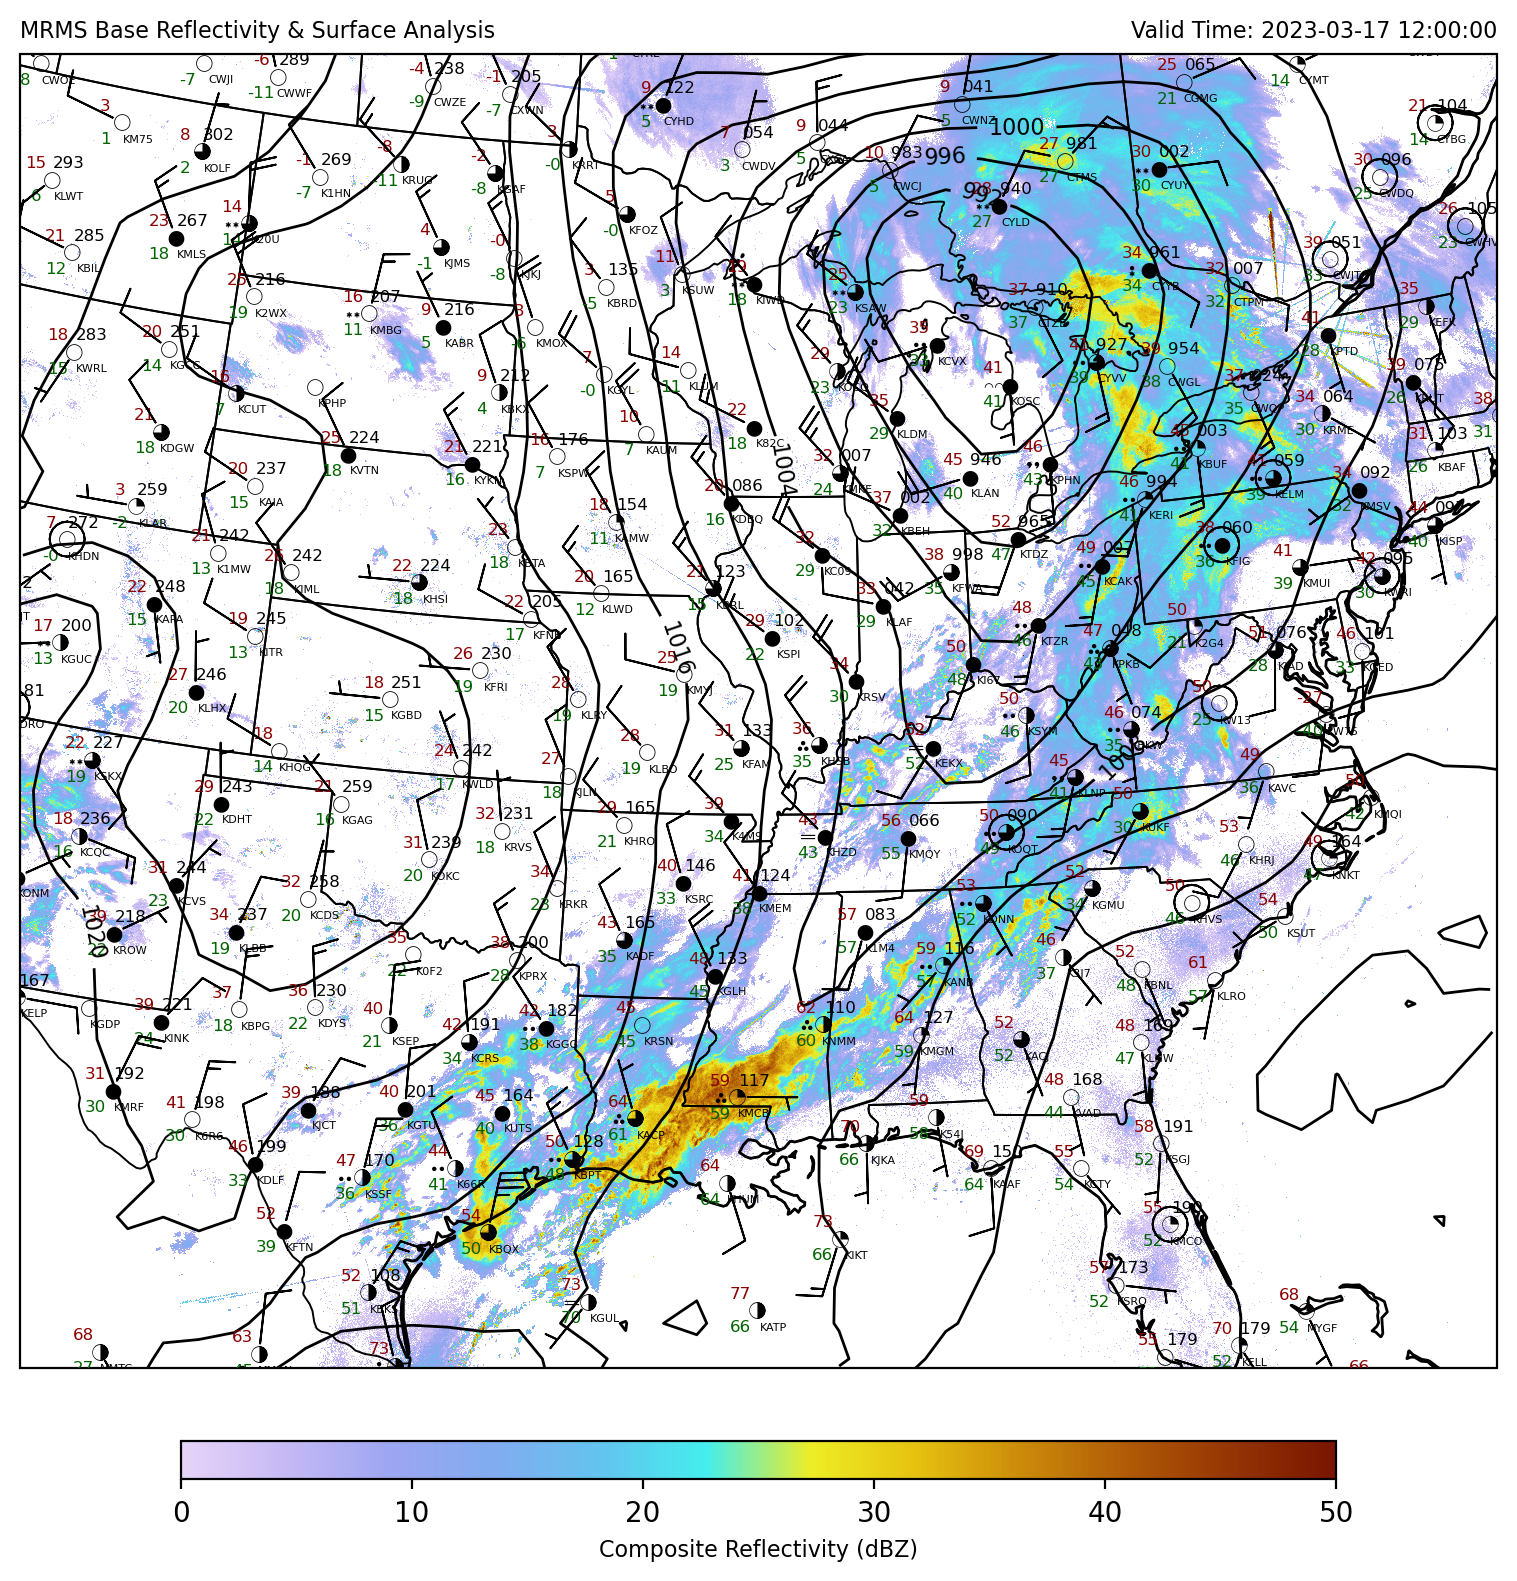

In [197]:
point_density = 150000.

#declutter surface station plots
point_locs = proj.transform_points(ccrs.PlateCarree(),df_trim['lon'].values,df_trim['lat'].values)
df_plot = df_trim[reduce_point_density(point_locs,point_density)]

ext = [lon_min, lon_max, lat_min, lat_max]
fig = plt.figure(figsize=(8, 8), dpi=200)
ax = plt.axes(projection=proj)
ax.set_extent(ext)

# Create a feature for States/Admin 1 regions at 1:10m from Natural Earth
ax.add_feature(cfeature.STATES,edgecolor='k',linewidth=0.7)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.0)

stationplot = StationPlot(ax,df_plot['lon'].values,df_plot['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=6)
stationplot.plot_parameter('NW',df_plot['temp']*(9.0/5.0)+32.0,color='darkred',fontsize=6)
stationplot.plot_parameter('NE',df_plot['pres'],color='black',formatter=lambda v: format(10 * v, '.0f')[-3:],fontsize=6)
stationplot.plot_parameter('SW',df_plot['dwpt']*(9.0/5.0)+32.0,color='darkgreen',fontsize=6)
stationplot.plot_text('SE',df_plot['name'].values,color='k',fontsize=4)
stationplot.plot_barb(np.array(df_plot['u'].values,dtype=float),np.array(df_plot['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)
stationplot.plot_symbol('C',df_plot['sky_cvr'].values,sky_cover)
stationplot.plot_symbol('W',df_plot['wx'].values,current_weather,fontsize=8)

#plot presure contours
cs = plt.contour(slpgridx,slpgridy,SLP[-1],colors='k',levels=list(range(900,1046,4)),linewidths=1)
plt.clabel(cs, inline=1, fontsize=8, fmt='%i')

valmask = np.ma.masked_where(radar.unknown <= 0, radar.unknown)
cs = plt.pcolormesh(radar.longitude, radar.latitude, valmask, vmin=0, vmax=50,
                    cmap='pyart_LangRainbow12', transform=projection)
plt.colorbar(cs, orientation='horizontal', pad=0.05, shrink=0.75, fraction=0.05, aspect=30).set_label(label='Composite Reflectivity (dBZ)',size=8)
plt.title(f'MRMS Base Reflectivity & Surface Analysis', loc='left',fontsize=8)
vtime = np.datetime64(dt).astype('O')
plt.title('Valid Time: {}'.format(vtime), loc='right',fontsize=8)
outfile_date = dt.strftime('%Y%m%d_%H%M')
fig.tight_layout()
fig.savefig(f'{outfile_date}_mosaic.png',bbox_inches='tight')